<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sns.set_style("whitegrid", {'axes.grid' : False})

# from tqdm.notebook import tqdm
from tqdm.auto import tqdm

## Data

In [2]:
df = pd.read_csv('../data/transactions_train.csv')

In [3]:
df = df.sort_values(['client_id', 'trans_date'])

In [4]:
y = pd.read_csv('../data/train_target.csv')

In [5]:
df = pd.merge(df, y, on='client_id')

In [10]:
print('before downsampling:\n', df.dtypes)
df['client_id'] = pd.to_numeric(df['client_id'], downcast='unsigned')
df['trans_date'] = pd.to_numeric(df['trans_date'], downcast='unsigned')
df['small_group'] = pd.to_numeric(df['small_group'], downcast='signed')
df['amount_rur'] = pd.to_numeric(df['amount_rur'], downcast='float')

print('after downsampling:\n',df.dtypes)

before downsampling:
 client_id        int64
trans_date       int64
small_group      int64
amount_rur     float64
bins             int64
dtype: object
after downsampling:
 client_id       uint16
trans_date      uint16
small_group      int16
amount_rur     float32
bins             int64
dtype: object


In [26]:
groups = pd.read_csv('../data/small_group_description.csv')

In [58]:
df['weekday'] = df['trans_date'] % 7

## EDA

Для сегментирования отдельных групп пользователей, провести кластеризацию пользователей и использовать метки получившихся классов в качестве предсказываемой переменной. Обученные эмбединги использовать для предсказания реальных данных(в нашей задаче это возрастные группы).

Кластеризация пользователей на основе handmade признаков обоснование выбора признаков с использованием EDA. Кластеризация пользователей любым способом, который кажется пригодным(с учетом особенностей данных). Визуализация категорий пользователей с использованием алгоритмов понижения размерности данных.

In [21]:
np.random.seed(228)

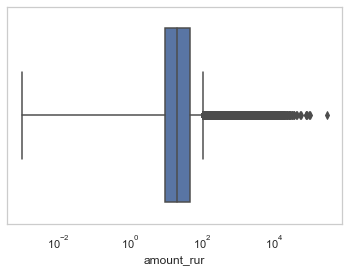

In [25]:
sns.boxplot(x=df['amount_rur'].sample(1000000))
plt.xscale('log')

In [52]:
tmp = df.groupby('small_group')[['amount_rur']].agg(['mean', 'count', 'max', 'min']).reset_index()
tmp.columns =['small_group_code', 'mean', 'count', 'max', 'min']
tmp = tmp.set_index('small_group_code')
tmp = tmp.join(groups, on='small_group_code', how='outer').reset_index(drop=True)
tmp = tmp.sort_values('count', ascending=False)
tmp

,mean,count,max,min,small_group,small_group_code
1,41.666897,8131374.0,22447.980469,0.002000,Сетевые супермаркеты и продуктовые магазины,1
11,21.339022,3202881.0,11515.068359,0.001000,Фастфуд и кафе,11
3,19.819042,2428984.0,24261.560547,0.001000,Оплата телефона и связи,3
15,21.617123,1427077.0,13318.199219,0.005000,Несетевые супермаркеты и продуктовые магазины,15
4,34.616478,1207604.0,38081.308594,0.001000,Аптеки,4
...,...,...,...,...,...,...
198,45.794998,1.0,45.794998,45.794998,Услуги починки (металлические изделия),199
199,126.484001,1.0,126.484001,126.484001,Телеграф,200
201,68.968002,1.0,68.968002,68.968002,Бетонные работы,203
202,NaN,NaN,NaN,NaN,Снегоходы,194


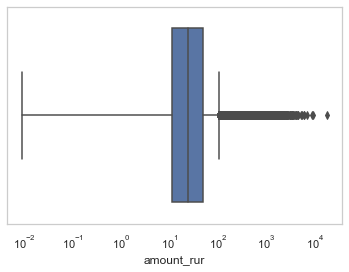

In [49]:
mask = df['small_group'] == 1
sns.boxplot(x=df[mask]['amount_rur'].sample(1000000))
plt.xscale('log')

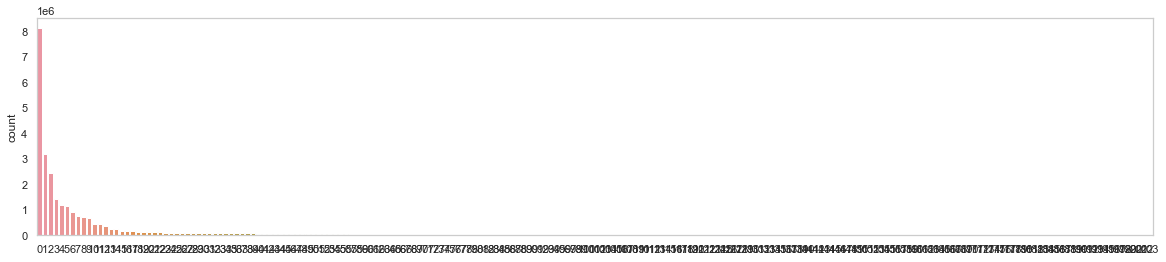

In [47]:
fig, axs = plt.subplots(figsize=(20, 4))

sns.barplot(x=list(range(len(tmp))), y=tmp['count'].sort_values(ascending=False));

In [48]:
quantiles = np.arange(0.1, 1.1, 0.1)
counts = [int(tmp['count'].quantile(i)) for i in quantiles]
quantiles = pd.DataFrame({'quantile': quantiles, 'count': counts})
quantiles

,quantile,count
0,0.1,34
1,0.2,183
2,0.3,516
3,0.4,1174
4,0.5,3287
5,0.6,11474
6,0.7,23829
7,0.8,61634
8,0.9,121845
9,1.0,8131374


In [53]:
tmp = tmp.sort_values('mean', ascending=False)
tmp

,mean,count,max,min,small_group,small_group_code
173,1352.014282,100.0,9793.549805,0.824,Металлопрокат,173
170,1344.033936,209.0,7440.359863,1.294,Окна и двери,170
181,1275.825684,73.0,16371.612305,0.190,Прочие отели (аппартаменты),181
178,1187.892944,38.0,13553.929688,3.450,Камины и печи,178
190,1180.543213,28.0,9159.056641,4.579,Услуги починки (кондиционеры и холодильники),190
...,...,...,...,...,...,...
115,17.517340,19657.0,2426.331055,0.043,"Видео (онлайн-кинотеатры, онлайн-каналы, видео...",115
47,14.888980,37602.0,1831.812012,0.043,Пекарня,47
196,12.542286,7.0,29.863001,4.313,Ортопедия,197
202,NaN,NaN,NaN,NaN,Снегоходы,194


In [50]:
tmp = tmp.sort_values('max', ascending=False)
tmp

,mean,count,max,min,small_group,small_group_code
36,77.394745,372445.0,400086.781250,0.004000,Косметика,36
80,391.396545,45405.0,319685.687500,0.043000,Аксессуары (драгоценности и часы),80
24,197.395203,462932.0,291837.218750,0.002000,Одежда,24
14,800.021484,28905.0,284318.687500,0.014000,Автодилеры и автосервис,14
21,221.938492,121548.0,219405.437500,0.009000,Больницы и поликлинники,21
...,...,...,...,...,...,...
201,68.968002,1.0,68.968002,68.968002,Бетонные работы,203
198,45.794998,1.0,45.794998,45.794998,Услуги починки (металлические изделия),199
196,12.542286,7.0,29.863001,4.313000,Ортопедия,197
202,NaN,NaN,NaN,NaN,Снегоходы,194


In [51]:
tmp = tmp.sort_values('min', ascending=False)
tmp

,mean,count,max,min,small_group,small_group_code
188,167.153000,1.0,167.153000,167.153000,Остеопаты,188
192,394.421753,4.0,800.364990,151.929993,Аренда оборудования для грузовиков и трейлеров,192
199,126.484001,1.0,126.484001,126.484001,Телеграф,200
201,68.968002,1.0,68.968002,68.968002,Бетонные работы,203
200,72.919502,2.0,93.788002,52.050999,Скорая помощь,202
...,...,...,...,...,...,...
74,39.743542,17072.0,25286.824219,0.001000,Благотворительность и краудфандинг,74
66,308.694061,10944.0,9001.336914,0.001000,Мужская одежда,66
53,143.307175,30098.0,35205.031250,0.001000,Оплата налогов,53
202,NaN,NaN,NaN,NaN,Снегоходы,194


**maybe drop transactions from categories with low count**

to try

count num transactions in each category (count vectorizer)

count avg by customer in each category

max in each category

min in each category

averages by weekday